## Beyond Euler-Cromer: Midpoints, Leaping frogs, Verlet,  and more.

We started our journey with the simple Euler method. If we use Euler to integrate the equation of motion for a Newtonian particle with constant acceleration $a$, we have two equations for the position and velocity:

$$\begin{align}
v_{i+1} = v_i + a_i \Delta t \tag{Eq. 1}\\
x_{i+i} = x_i + v_i \Delta t \tag{Eq. 2}\\
\end{align}$$

But this didn't work for oscillatory motion --- we discovered that this simple integrator had very poor stability. A lsight modification of Euler rendered it *symplectic*:

$$\begin{align}
v_{i+1} = v_i + a_i \Delta t \tag{Eq. 3}\\
x_{i+i} = x_i + v_{i+1} \Delta t \tag{Eq. 4}\\
\end{align}$$

Now we found that our integrator conserves energy, at least when integrated over 1/2 period of oscillation. 

But a look at the figure below reminds us that neither one of these algorithms will follow the trajectory of a classical particle exactly. Of course, we can reduce the error by reducing the timestep, but this increases the cost of the calculation --- more integration steps to reach the same total simulation time. Moreover, the errors accumulate, so that if we need to follow the particle for a very long time, by the end it's position in the computer may be quite far form its actual position.
![midpoint](./midpoint.jpg)

What do we do for problems (like the one in project 2) for which we need much better accuracy in the position? Never fear, there are many other integrators that we can dream up. For example, what if we use the velocity at the *midpoint* between two integration steps to predict the next position, like this? 

$$\begin{align}
v_{i+1} = v_i + a_i \Delta t \tag{Eq. 4}\\
x_{i+i} = x_i + \frac{v_{i+1}+v_i}{2} \Delta t \tag{Eq. 5}\\
\end{align}$$

According to the drawing, this will determine the next position **exactly!!** (within machine precision) Straight magic, bruh!

**Question:** Why does this work? Or, when will it *not* work? (Hint: Think of a trajectory that you can draw through the positions at $t_1$ and $t_2$ for which this method fails. What is different about this trajectory compared to the drawing?)

Let's implement a midpoint method for a single ball undergoing perfectly elastic collisions with a hard surface, and compare it to Euler and Euler-Cromer.

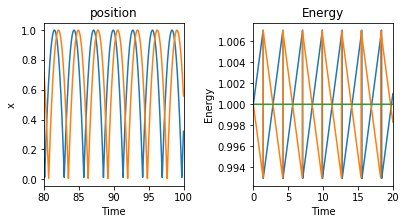

In [7]:
import matplotlib.pyplot as plt
import numpy as np


#initial position and velocity
x0 = 1.0
v0 = 0.0
a = -1.0 #g normalized to 1.

dt = 0.01
eps = 0.005

x_euler = []
x_ec = []
x_mid = []
v_euler = []
v_ec = []
v_mid = []
E_euler = []
E_ec = []
E_mid = []
time = []

E = 0.5*v0**2 + x0

E_euler.append(E)
E_ec.append(E)
E_mid.append(E)

x_euler.append(x0)
x_ec.append(x0)
x_mid.append(x0)
v_euler.append(v0)
v_ec.append(v0)
v_mid.append(v0)
time.append(0.0)

imax = 10000
for i in range (1,imax):
    
    #euler integrator for position:
    v_new = v_euler[i-1] + a*dt
    x_new = x_euler[i-1] + v_euler[i-1]*dt
    if x_new < eps: # check for collision with ground.
        v_new = -1.0*(v_euler[i-1]) #reflect velocity
        x_euler[i-1] = np.fabs(x_euler[i-1]) #in case x < 0
        x_new = x_euler[i-1] + v_euler[i-1]*dt #re-update position
    v_euler.append(v_new)
    x_euler.append(x_new)
    E = 0.5*v_euler[i]**2 + x_euler[i]
    E_euler.append(E)
    
    #e-c integrator for position:
    v_new = v_ec[i-1] + a*dt
    x_new = x_ec[i-1] + v_new*dt
    if x_new < eps:
        v_new = -1.0*(v_ec[i-1])
        x_ec[i-1] = np.fabs(x_ec[i-1])
        x_new = x_ec[i-1] + v_new*dt
    v_ec.append(v_new)
    x_ec.append(x_new)
    E = 0.5*v_ec[i]**2 + x_ec[i]
    E_ec.append(E)
    
    
    #midpoint integrator for new position:
    v_new = v_mid[i-1] + a*dt
    x_new = x_mid[i-1] + ((v_new + v_mid[i-1])/2.0)*dt
    if x_new < eps:
        v_new = -1.0*v_mid[i-1]
        x_mid[i-1] = np.fabs(x_mid[i-1]) 
        x_new = x_mid[i-1] + ((v_new + v_mid[i-1])/2.0)*dt
    v_mid.append(v_new)
    x_mid.append(x_new)
    E = 0.5*v_mid[i]**2 + x_mid[i]
    E_mid.append(E)

    t_new = i*dt
    time.append(t_new)
    

plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_title('position')
ax.set_xlabel('Time')
ax.set_ylabel('x')
ax.set_xlim(left=80) # change these limits to 80 to 100
ax.set_xlim(right=100) # in order to see difference in integrators
#ax.set_ylim(top=0.02)
#ax.set_ylim(bottom=-0.02)
#plt.plot(time,x_euler)
plt.plot(time, x_ec)
plt.plot(time, x_mid)

ax2 = plt.subplot(132)
ax2.set_title('Energy')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.set_xlim(right=20)
plt.plot(time,E_euler)
plt.plot(time, E_ec)
plt.plot(time, E_mid)

plt.show()



All three of the schemes in the above example are *first order,* meaning that they are all of the form:

$$f(t+\Delta t) = f(t) +f^{\prime}\Delta t + \mathcal{O}(\Delta t)^2 \tag{Eq. 7}$$

The difference between them lies in what we use for $f^{\prime}$. Velocity at step $i$ (Euler), or step $i+1$ (E-C), or average of steps $i$ and $i+1$ (midpoint method). We have examined when these methods work and when they fail, and learned about the importance of conserving energy and of sometimes having a symplectic integrator.

But what if we need better accuracy? Note that so far we have mostly considered cases for which the acceleration is constant, and independent of position, which is a special case. Consider, for example, simulating a bunch of Argon atoms. In the gas state it's easy, and we don't need simulation. (Recall that Argon is very much an ideal gas.) But if we increase the density of the gas, at some point the atoms begin to interact with one another. Now we have a liquid --- and for liquids there aren't very many pen and paper calculations that can be done! In fact, in the early days of computer simulation, methods like the ones we are developing in the course were instrumental for testing theoretical approximations for the statistical mechanics of fluids.
___
**Question:** What is different about simulating something like liquid Ar as compared to the example above? (Think about the acceleration.) What would the structure of the code look like to run a classical simulation of a bunch of Ar atoms?
___
### Verlet Integrator
Since the force (and therefore acceleration) depends on the positions, we might need a more accurate integrator for the position. Awhile back, I mentioned that we could write down a discrete integrator for the position directly. Consider applying the (discretized) time derivative twice:

$$\begin{align}
\frac{d^2x}{dt^2} &= \frac{d}{dt}\left(\frac{dx}{dt}\right) \\
&=\frac{d}{dt}\frac{x_{i+1} - x_i}{\Delta t} \\
&= \frac{d}{dt} \left( \frac{x_{i+1}}{\Delta t}\right) - \frac{d}{dt} \left( \frac{x_{i}}{\Delta t}\right) \\
&=\frac{x_{i+1} - x_i}{\Delta t^2} - \frac{x_{i} - x_{i-1}}{\Delta t^2} \\
&= \frac{x_{i+1} - 2x_i + x_{i-1}}{\Delta t^2} \tag{Eq. 8}\\ 
\end{align}$$

The last line is the second-order finite difference approximation for the acceleration. To turn it into an integrator, rearrange Eq. 8 to obtain an expression for $x_{i+1}$:

$$x_{i+1} = 2x_i - x_{i-1} - a_i\Delta t^2 \tag{Eq. 9} $$

This last line is called the "Verlet integrator" after Loup Verlet, but has been discovered many times before he popularized it. 
___
**Question:** How do you get the acceleration at the $i^{th}$ iteration?
___
To determine the accuracy of a Verlet integrated trajectory, begin by expanding the position at $x(t_i)$ in both the forward and backward directions to third order in $\Delta t$. I'll write $x_i$ as $x(t_i)$ in order to make the time dependence more explicit for taking derivatives, which I'll denote using $\dot{x}(t_i)$, etc.

$$\begin{align}
x(t_i+\Delta t) &= x(t_i) + \dot{x}(t_i)\Delta t + \frac{1}{2}\ddot{x}(t_i)\Delta t^2 + \frac{1}{3!}\dddot{x}(t_i) \Delta t^3 + \mathcal{O}(\Delta t^4) \tag{Eq. 10} \\
x(t_i-\Delta t) &= x(t_i) - \dot{x}(t_i)\Delta t + \frac{1}{2}\ddot{x}(t_i)\Delta t^2 - \frac{1}{3!}\dddot{x}(t_i) \Delta t^3 + \mathcal{O}(\Delta t^4)  \tag{Eq. 11} \\
\end{align}$$

Now add Eqs. 10 and 11 together. All of the odd terms cancel, leaving us with the Verlet integrator...but now we have shown that it is accurate to $4^{th}$ order in time:

$$x(t_i+\Delta t) = 2x(t_i) - x(t_i-\Delta t) + \ddot{x}(t_i)\Delta t^2 +\mathcal{O}(\Delta t^4) \tag{Eq. 12}$$
___
**Question:** What do you do if you want the velocities too?
___
Now we subtract Eqs. 10 and 11 to obtain:
$$\dot{x}(t_i) = \frac{1}{2\Delta t}[x(t+\Delta t) - x(t-\Delta t)] + \mathcal{O}(\Delta t^2) \tag{Eq. 13}$$

So, we can integrate the positions without knowing the velocities to 4th order accuracy, and get an estimate for the velocities with minimal additional overhead that is accurate to second order. 
___
**Question:** What might you need the velocities for?
___
### Velocity Verlet integrator 
An alternative is to write an integrator for the position using the forward step in Eq. 10:

$$x(t_i+\Delta t) = x(t_i) + \dot{x}(t_i)\Delta t + \frac{1}{2}\ddot{x}(t_i)\Delta t^2 \tag{Eq. 14}$$

And use a midpoint approximation for the velocity:

$$\dot{x}(t_i+\Delta t) \approx \dot{x}(t_i) + \frac{\Delta t}{2}(\ddot{x}(t_i+\Delta t) + \ddot{x}(t_i)) \tag{Eq. 15}$$

These last two equations are called "Velocity Verlet." If you substitute Eq. 15 into Eq. 14, you can show that Velocity Verlet is identical to Verlet as far as the positions are concerned (same estimator, same accuracy). They both achieve the same order of accuracy for the velocities, but using different expressions.
___
**Question:** How is Eq. 14 related to the basic Euler integrator?
___
## A more fundamental approach: The Liouville operator 

In classical mechanics we learn a more formal way to discuss the time evolution of a system of particles. We introduce the "Liouville operator" $\mathcal{L}$, which evolves in time any function $f(\mathbf{r}^N,\mathbf{p}^N,t)$ that depends on the coordinates $\mathbf{r}^N$ and momenta $\mathbf{p}^N$ of a system of $N$ particles:

$$\frac{\partial f}{\partial t} = -i\mathcal{L}f \tag{Eq. 16}$$

for which we can immediately write down a formal solution:

$$f(t) = \text{exp}(-i\mathcal{L}t)f(0) \tag{Eq. 17}$$

Of interest to us is to consider applying $\mathcal{L}$ to evolve a classical system in increments of size $\Delta t$. In particular, if we evolve a system through $n$ successive steps such that $t = n\Delta t$:

$$\text{exp}(i\mathcal{L}t) = \left[\text{exp}(i\mathcal{L}\Delta t) \right]^n \tag{Eq. 18}$$

Now, the Liouville operator is a special instance of the Poisson bracket:

$$\mathcal{L} \equiv i\{H,.\} \tag{Eq. 19}$$

where $H$ is the Hamiltonian of the system. This means that the Liouville operator can be divided into parts that depend only on the positions and momenta:

$$i\mathcal{L} = i\mathcal{L}_r + i\mathcal{L}_p \tag{Eq. 20}$$

with 

$$i\mathcal{L}_r = \sum_{i=1}^N\dot{\mathbf{r}}_i\frac{\partial}{\partial\mathbf{r}_i} \tag{Eq. 21}$$

and
$$i\mathcal{L}_p = \sum_{i=1}^N\mathbf{F}_i\frac{\partial}{\partial\mathbf{p}_i} \tag{Eq. 22}$$

If $\Delta t$ is small enough, we can approximate the exp inside the square brackets of Eq. 18 (ie, the application of a single timestep) as (this is not exact, since $\mathcal{L_p}$ and $\mathcal{L_r}$ don't commute):

$$\text{exp}(i\mathcal{L}\Delta t) \approx \text{exp}\left(i\frac{1}{2}\mathcal{L_p}\Delta t\right)\text{exp}\left(i\mathcal{L_r}\Delta t\right)\text{exp}\left(i\frac{1}{2}\mathcal{L_p}\Delta t\right) \tag{Eq. 23}$$

We can then use a Taylor series expansion of the exponential function in Eq. 22 keeping terms up to second order. And guess what? That gives us exactly the Velocity Verlet integrator!

What have we learned and why is it useful? Well, we have now shown Velocity Verlet to be a *well defined* appoximation for the propagator in Eq. 17. In turn, it is now possible to prove that the algorithm defined by Eq. 23 conserves phase space volume --- VV is symplectic! And, we now have a systematic way to obtain other algorithms, by dividing the application of the propagator in different ways. 


